# Predicting the levels of microplastics in the drinking water.

## Data Wranglers
*   Megan Aleman
*   Michelle Brown
*   Severin Light
*   Nathan Simpson

# Introduction: (Copied from project proposal)
Microplastics are a growing concern globally, and pollution from one side of the world will get into the water system and can impact water sources all over the globe. While the health risks of PE (Polyethylene) remains uncertain when consumed, there is the possibility that the plastic particles can absorb and transport harmful chemicals. We are planning to predict the levels of PE in drinking water based on geographic location. We will be using latitude and longitude to measure the locations, size of the microplastic, as well as analyzing trends along country and region borders. Predicting the levels of PE in drinking water is an important step in increasing awareness and supporting change that can reduce these levels in the future.

## Dataset: (Copied from project proposal)
The dataset we decided on is the 'Microplastics in Drinking Water' (specifically the file titled “Microplastics Sample Data (wide)”), which was published by the California State Water Resources Control Board on catalog.data.gov. Each row in this dataset indicates a water sample recorded and columns with information related to that sample. Some of the particular columns that we are interested in are: microplastic materials and types (there is a column for each microplastic type/material and the amount of it present in the sample),colors, tap vs bottled water, and locations where the data was gathered as well as their approximate longitudes and latitudes. Because we are only focusing on the PE (Polyethylene) material, the other “Material” columns will need to be dropped, as they won’t be relevant to our prediction.

Dataset Origin: https://catalog.data.gov/dataset/microplastics-in-drinking-water

Validation Rules (Sample Data): https://data.ca.gov/dataset/e7624fce-c058-4fa1-a29f-2594d8f8f160/resource/2cffd2f1-451f-4253-9050-15c2a9bb298d/download/validation_rules_samples_merged.csv

Microplastics Sample Data (wide): https://data.ca.gov/dataset/e7624fce-c058-4fa1-a29f-2594d8f8f160/resource/b027a5ef-d42e-415c-b9b9-257c1bd5ae89/download/samples_geocoded.csv

## Goal:
Our goal is to utilize machine learning to take in information from our chosen dataset and be able to reliably predict the safety of water for consumption based on the amount of microplastics found in similar sources.

## Features:
* Countries
* Source
* Concentration

# Data Exploration:

## Sample Information
*  1. Location - Combination of Specific Location, Cities, and Countries. (all at least contain the Country)
*  2. Countries - Country where the sample was taken
*  3. Source - Sample type of bottled water / tap water
*  4. Concentration - Amount of particles in a given sample
*  5. Concentration_Units - Unit of measurement for given sample

## Material Concentrations
*  6. Material_PEST - ***I can't find a definite definition for this***
*  7. Material_PE - (Unsure) Concentrations of Polyethylene
*  8. Material_PP - (Unsure) Concentrations of Polypropylene
*  9. Material_PA - (Unsure) Concentrations of Polyamide
*  10. Material_PS - (Unsure) Concentrations of Polystyrene
*  11. Material_CA - (Unsure) Concentrations of Cellulose Acetate
*  12. Material_PVC - (Unsure) Concentrations of Polyvinyl Chloride
*  13. Material_PET - (Unsure) Concentrations of Polyethylene Terephthalate
*  14. Material_Other - Other Material Concentrations

## Sample Types
*  15. Morphology_Fragment - (Unsure) Sample type listed either as a percentage of the sample being Fragment or just 'present'
*  16. Morphology_Fiber - (Unsure) Sample type listed either as a percentage of the sample being Fiber or just 'present'
*  17. Morphology_Nurdle - (Unsure) Sample type listed either as a percentage of the sample being Nurdle or just 'present'
*  18. Morphology_Foam - (Unsure) Sample type listed either as a percentage of the sample being Foam or just 'present'

## Microplastic Sizes
*  19. Size_20_100um - (Unsure) Percentage of sample within size range of 20-100um
*  20. Size_10_20um - (Unsure) Percentage of sample within size range of 10-20um
*  21. Size_5_10um - (Unsure) Percentage of sample within size range of 5-10um

## Esitmated Collection Location
*  22. Approximate_Latitude - Estimated Latitude for sample's origin
*  23. Approximate_Longitude - Estimated Longitude for sample's origin






In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor

# allow output to span multiple output lines in the console
pd.set_option('display.max_columns', 500)
# change default plot size
rcParams['figure.figsize'] = 9,7
df = pd.read_csv("https://data.ca.gov/dataset/e7624fce-c058-4fa1-a29f-2594d8f8f160/resource/b027a5ef-d42e-415c-b9b9-257c1bd5ae89/download/samples_geocoded.csv")



# Drop all columns that have less than 40 data values
# Doesn't seem to work for all columns for some reason, but still helps
column_counts = df.count()
mask = column_counts.where(column_counts >= 40).notna()
df = df.loc[:, mask]

# Annoying me
df = df.drop(['Subsample_ID'], axis=1)
df = df.drop(['Sample_ID'], axis=1)
df = df.drop(['DOI'], axis=1)

# Drop NAN and 'Present' values for PE material
df = df[df['Material_PE'] != 'Present']
df.dropna(subset=['Material_PE'], inplace=True)
df.dropna(subset=['Material_PP'], inplace=True)
df.dropna(subset=['Countries'], inplace=True)

#Convert to float
df['Material_PE'] = df['Material_PE'].astype(float)
df['Material_PP'] = df['Material_PP'].astype(float)
df['Approximate_Latitude'] = df['Approximate_Latitude'].astype(float)
df['Approximate_Longitude'] = df['Approximate_Longitude'].astype(float)


# # This doesn't make much sense.. ? Am I doing soemthing wrong, or is the data off?
# # Would hate to drop the data.
# mask = df['Concentration_Units'] == 'particles/m3'
# # Multiply by 1000 to convert from particles/m3 to particles/L
# df.loc[mask, 'Concentration'] = df.loc[mask, 'Concentration'].astype(float) * 1000
# # Change name to Particles/L
# df.loc[mask, 'Concentration_Units'] = 'particles/L (prev m3)'

In [ ]:
# Define a function to convert concentration values to numeric
def convert_to_numeric(value):
    try:
        # If the value is already a float, return it as is
        if isinstance(value, float):
            return value
        # If the value is an integer, convert it to float
        elif isinstance(value, int):
            return float(value)
        # If the value is a range, take the maximum
        elif '-' in value:
            start, end = map(float, value.split('-'))
            return max(start, end)
        # If the value is 0, return NaN
        elif value == 0:
            return float('nan')
        # If the value is a date range, return NaN
        elif 'Jan' in value or 'May' in value:
            return float('nan')
        # Otherwise, convert the value to float
        else:
            return float(value)
    except ValueError:
        return float('nan')

# Convert 'Concentration' column to numeric
df['Concentration'] = df['Concentration'].apply(convert_to_numeric)

# Drop rows with NaN values in 'Concentration' column
df = df.dropna(subset=['Concentration'])

# Group by 'Countries' and calculate the maximum concentration for each country
max_concentration_by_country = df.groupby('Countries')['Concentration'].max()

# Sort the countries by maximum concentration
max_concentration_by_country = max_concentration_by_country.sort_values()

# Group by 'Countries' and calculate the average concentration for each country
avg_concentration_by_country = df.groupby('Countries')['Concentration'].mean()

# Sort the countries by average concentration
avg_concentration_by_country = avg_concentration_by_country.sort_values()

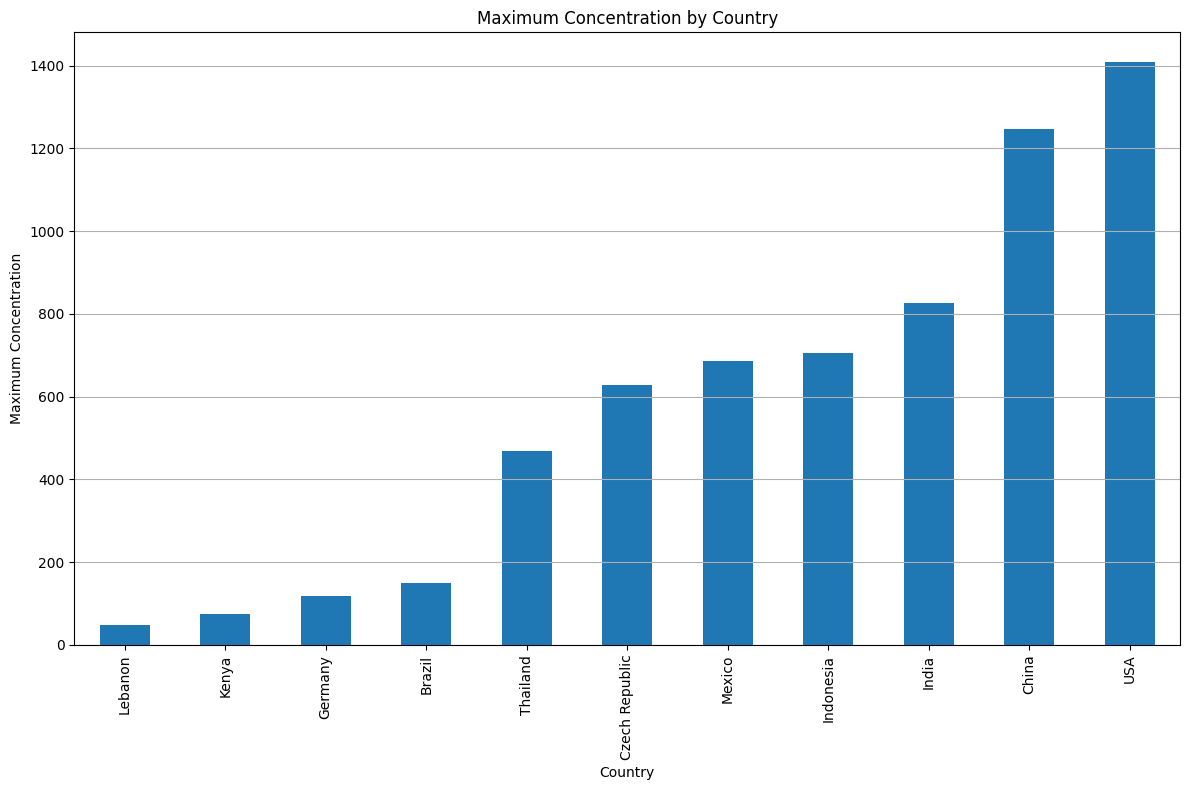

In [ ]:
# Plot bar graph
plt.figure(figsize=(12, 8))
max_concentration_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Maximum Concentration')
plt.title('Maximum Concentration by Country')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

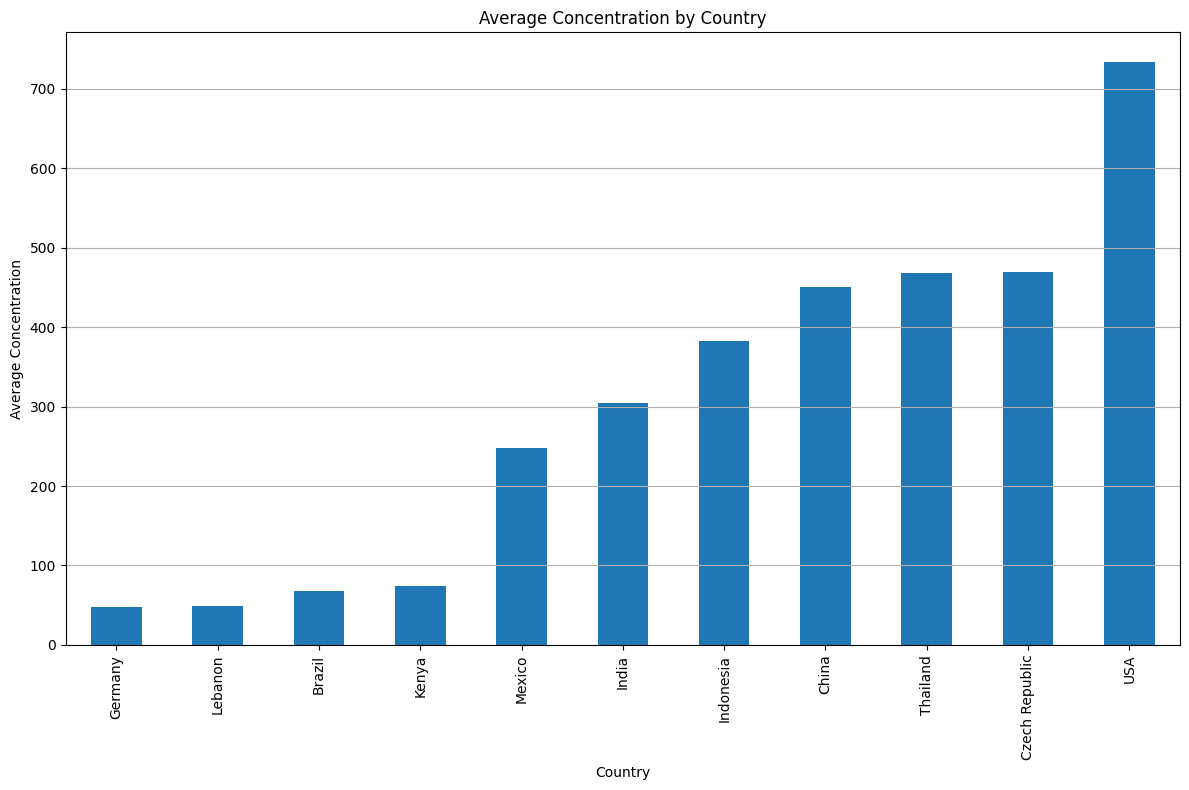

In [ ]:
# Plot bar graph
plt.figure(figsize=(12, 8))
avg_concentration_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Average Concentration')
plt.title('Average Concentration by Country')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

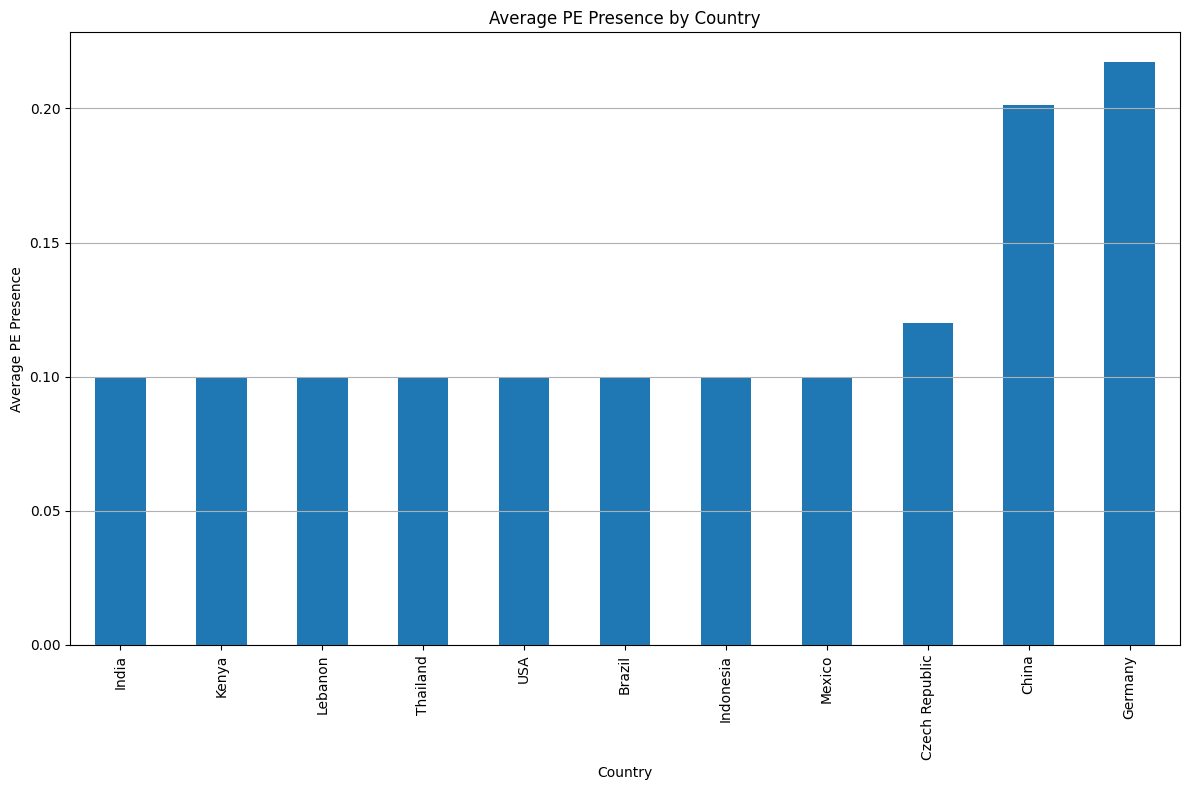

Countries
India             0.100000
Kenya             0.100000
Lebanon           0.100000
Thailand          0.100000
USA               0.100000
Brazil            0.100000
Indonesia         0.100000
Mexico            0.100000
Czech Republic    0.120000
China             0.201127
Germany           0.217500
Name: Material_PE, dtype: float64


In [ ]:
# Of remaining rows left w/usuable data, find the avg PE portion of the water sample for each country
avg_pe_presence_by_country = df.groupby('Countries')['Material_PE'].mean()
avg_pe_presence_by_country = avg_pe_presence_by_country.sort_values(ascending=True)

# Plot the bar graph
plt.figure(figsize=(12, 8))
avg_pe_presence_by_country.plot(kind='bar')
plt.xlabel('Country')
plt.ylabel('Average PE Presence')
plt.title('Average PE Presence by Country')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# Displays the values in text for understanding
print(avg_pe_presence_by_country)

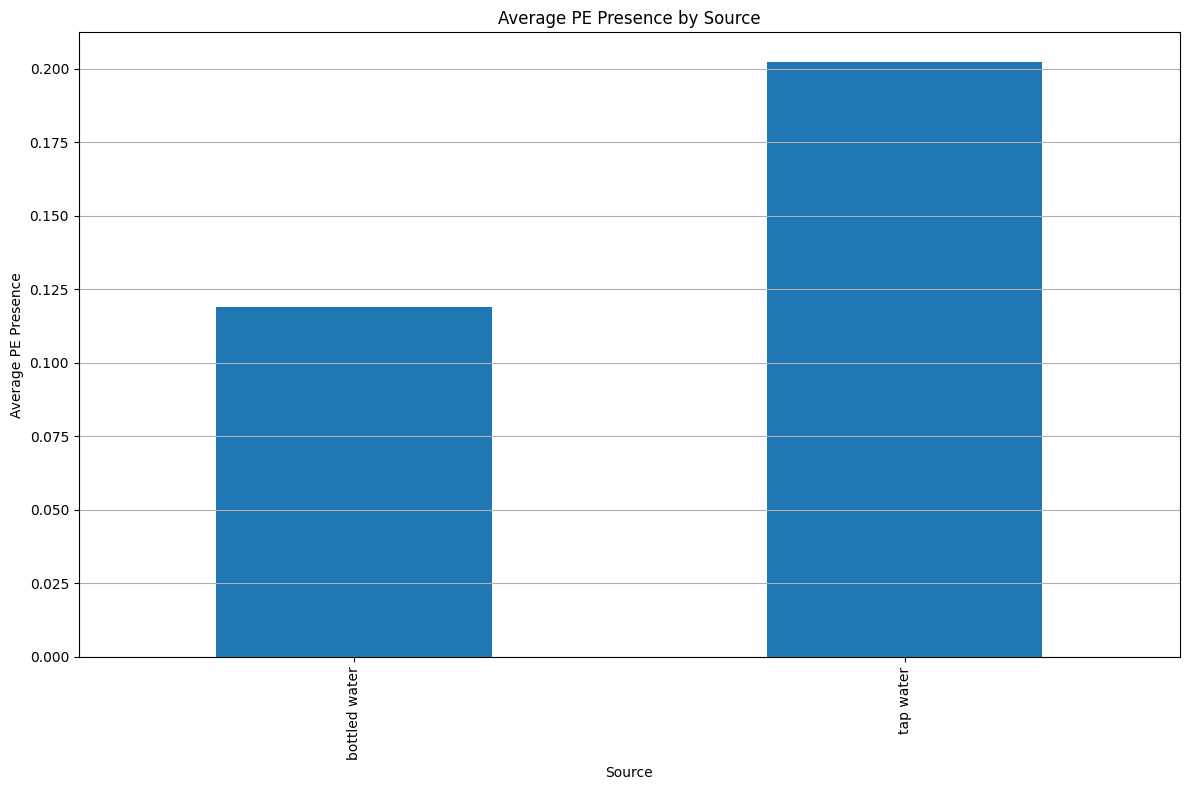

In [ ]:
# Compute the average amount of PE by water source
avg_pe_presence_by_source = df.groupby('Source')['Material_PE'].mean()
avg_pe_presence_by_source = avg_pe_presence_by_source.sort_values(ascending=True)

# Plot the bar graph
plt.figure(figsize=(12, 8))
avg_pe_presence_by_source.plot(kind='bar')
plt.xlabel('Source')
plt.ylabel('Average PE Presence')
plt.title('Average PE Presence by Source')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

<Figure size 1200x800 with 0 Axes>

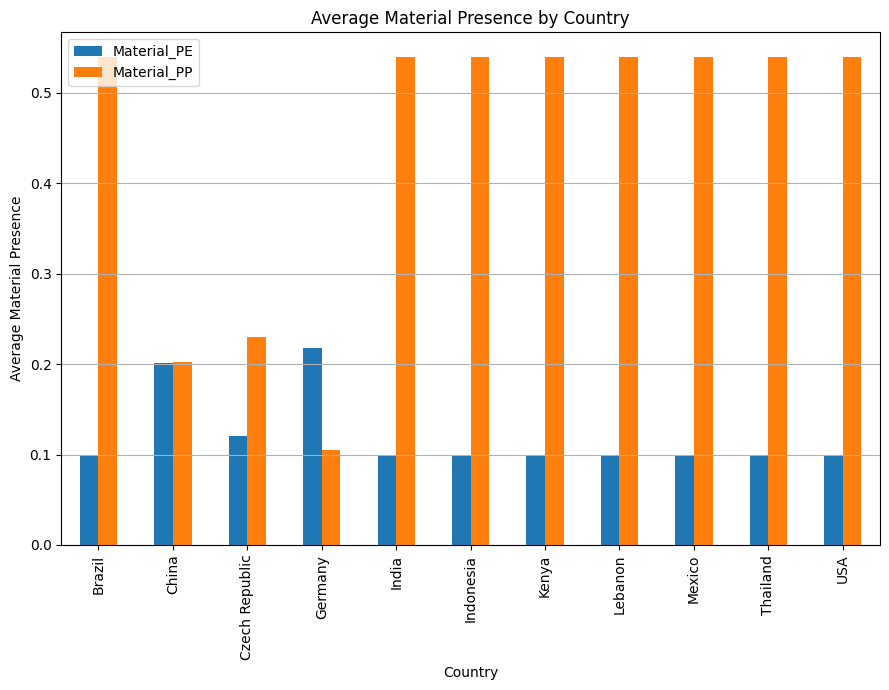

In [ ]:
# Compute the average amount of PE and PP by country
avg_material_by_country = df.groupby('Countries')[['Material_PE', 'Material_PP']].mean()

plt.figure(figsize=(12, 8))
avg_material_by_country.plot(kind='bar')
plt.title('Average Material Presence by Country')
plt.xlabel('Country')
plt.ylabel('Average Material Presence')
plt.grid(axis='y')
plt.legend(['Material_PE', 'Material_PP'])
plt.tight_layout()
plt.show()

In [ ]:
# Select columns to keep
columns_to_keep = ['Countries', 'Material_PE']

# Subset the dataframe
df_subset = df[columns_to_keep]

# Convert categorical variables to dummy variables
df_encoded = pd.get_dummies(df_subset)

# Define target
target = 'Material_PE'

# Define predictors
predictors = df_encoded.drop(columns=[target]).columns
X = df_encoded[predictors].values
y = df_encoded[target].values

# test/train split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

# Use Polynomial Features
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

# Fit the Random Forest model
rf = RandomForestRegressor(n_estimators=32, random_state=0) # Not too sure about this. RMSE is pretty high,
rf.fit(X_train_poly, y_train)                               # playing with the n_estimators value doesn't change much.

# Predict
predict = rf.predict(X_test_poly)

# Evaluate
mse = ((predict - y_test)**2).mean()
print("Mean Squared Error:", mse)
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

Mean Squared Error: 0.017387526246365925
Root Mean Squared Error: 0.13186176946471606
